# **Part 2: Improved Model, Clustering & Balanced Classification**

### **Step 1: Import Libraries and Start Spark Session**

In [1]:
# Importing required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator

# Python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Start Spark session
spark = SparkSession.builder.appName("ImprovedModel_Part2").getOrCreate()


### **Step 2: Load Dataset and Clean Column Names**

In [3]:
# Load and clean data
df = spark.read.csv("Dataset.csv", header=True, inferSchema=True)
df = df.toDF(*[c.strip() for c in df.columns])  # Clean column names
df = df.withColumn("target", col("CLASIFFICATION_FINAL").cast("int"))  # Convert target column


### **Step 3: Identify and Prepare Features**

In [4]:
numeric_cols = [c for c in df.columns if df.select(c).schema.fields[0].dataType.simpleString() in ['int', 'double'] and c != "target"]
categorical_cols = [c for c in df.columns if df.select(c).schema.fields[0].dataType.simpleString() == 'string']

# Defining feature steps
imputer = Imputer(inputCols=numeric_cols, outputCols=[f"{c}_imputed" for c in numeric_cols])
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid='keep') for c in categorical_cols]
feature_cols = [f"{c}_imputed" for c in numeric_cols] + [f"{c}_indexed" for c in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")
scaler = StandardScaler(inputCol="assembled_features", outputCol="features")


### **Step 4: Train Global Classification Model**

In [5]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestClassifier(labelCol="target", featuresCol="features", numTrees=100)
global_pipeline = Pipeline(stages=indexers + [imputer, assembler, scaler, rf])
global_model = global_pipeline.fit(train_df)
global_predictions = global_model.transform(test_df)


### **Step 5: Evaluate Global Model (Accuracy, F1, Precision, Recall)**

In [6]:
metrics = {
    "accuracy": "accuracy",
    "f1_score": "f1",
    "weighted_precision": "weightedPrecision",
    "weighted_recall": "weightedRecall"
}

global_scores = {}
print("Global Model Metrics:")
for name, metric in metrics.items():
    evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName=metric)
    score = evaluator.evaluate(global_predictions)
    global_scores[name] = score
    print(f"{name.title()}: {score:.4f}")


Global Model Metrics:
Accuracy: 0.9490
F1_Score: 0.9285
Weighted_Precision: 0.9245
Weighted_Recall: 0.9490


### **Step 6: Visualize Feature Importances and Confusion Matrix**

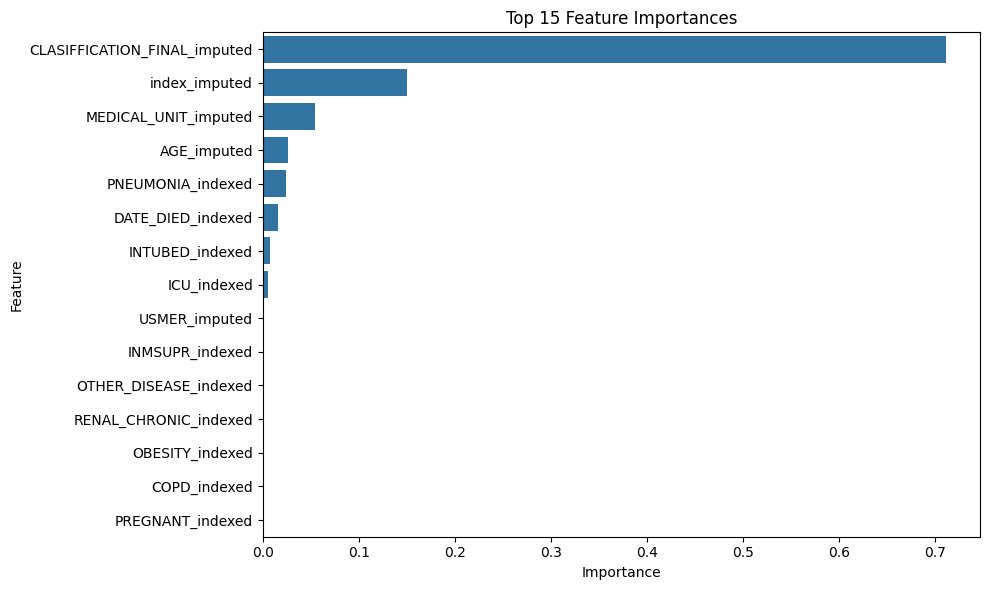

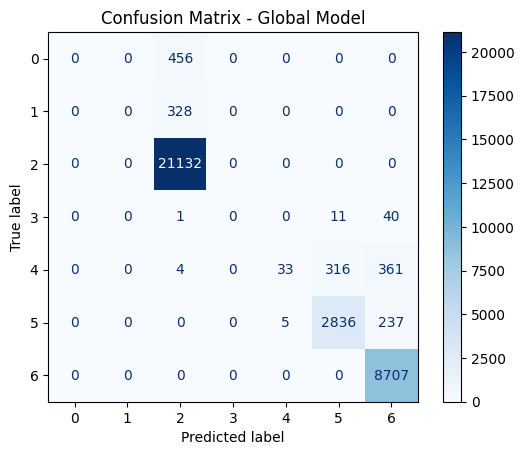

In [7]:
# Feature importance
features = feature_cols
importances = global_model.stages[-1].featureImportances.toArray()
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# Confusion matrix
conf_df = global_predictions.select("target", "prediction").toPandas()
cm = confusion_matrix(conf_df["target"], conf_df["prediction"])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Global Model")
plt.show()


### **Step 7: Cluster Data Using KMeans**

In [8]:
# Step 7: Prepare full preprocessing pipeline
preprocess_pipeline = Pipeline(stages=indexers + [imputer, assembler, scaler])
preprocess_model = preprocess_pipeline.fit(df)
processed_df = preprocess_model.transform(df)

# Apply KMeans clustering on scaled features
kmeans = KMeans(k=5, seed=1, featuresCol="features", predictionCol="cluster")
kmeans_model = kmeans.fit(processed_df)
clustered_df = kmeans_model.transform(processed_df)

# Reduce dimensionality with PCA for visualization
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(clustered_df)
pca_result = pca_model.transform(clustered_df)

# Convert for plotting
pdf = pca_result.select("pcaFeatures", "cluster", "target").toPandas()
pdf[['x', 'y']] = pd.DataFrame(pdf['pcaFeatures'].tolist(), index=pdf.index)



### **Step 8: Box Plot and Scatter Plot Visualization with PCA**

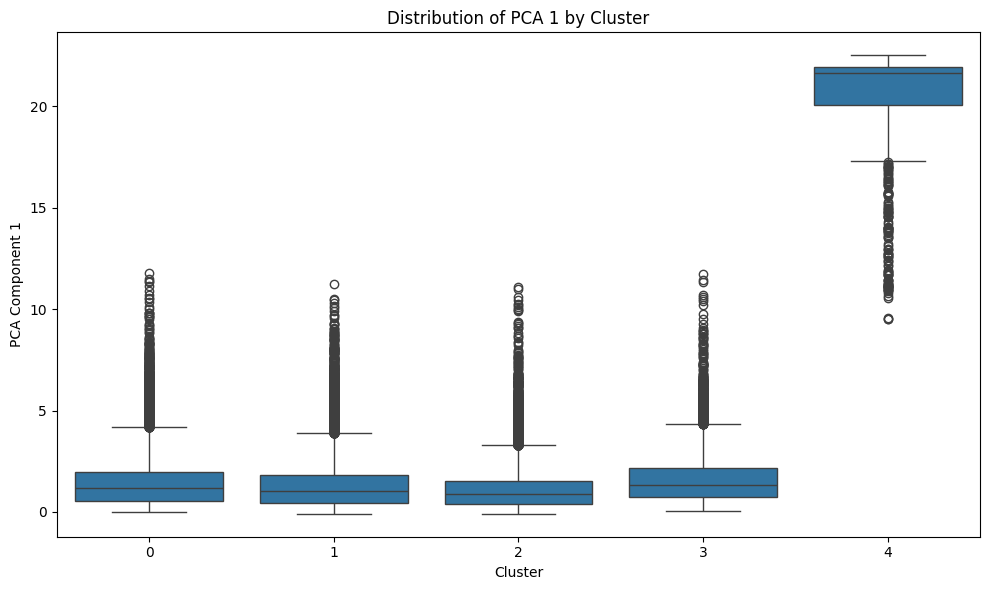

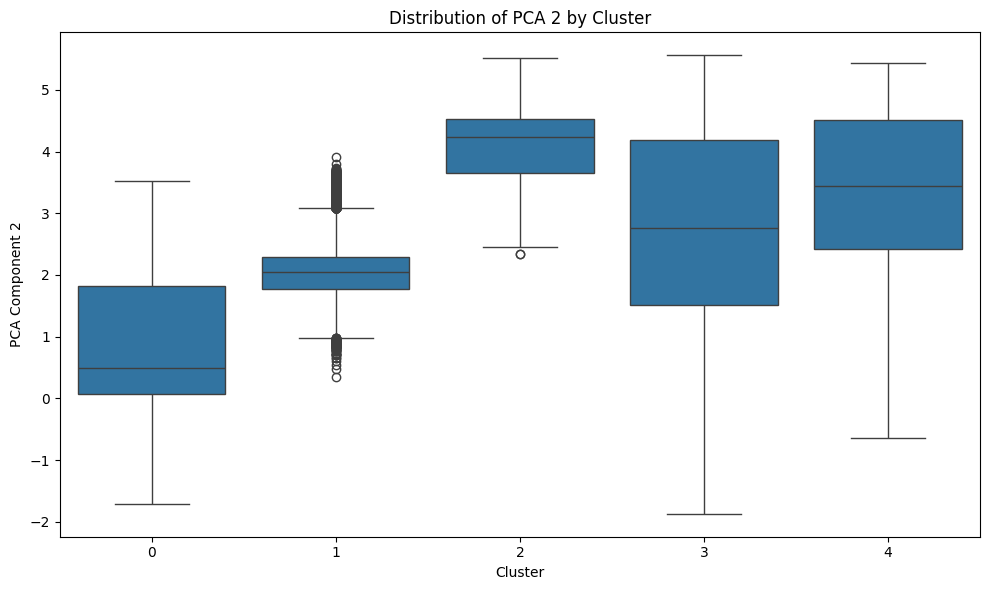

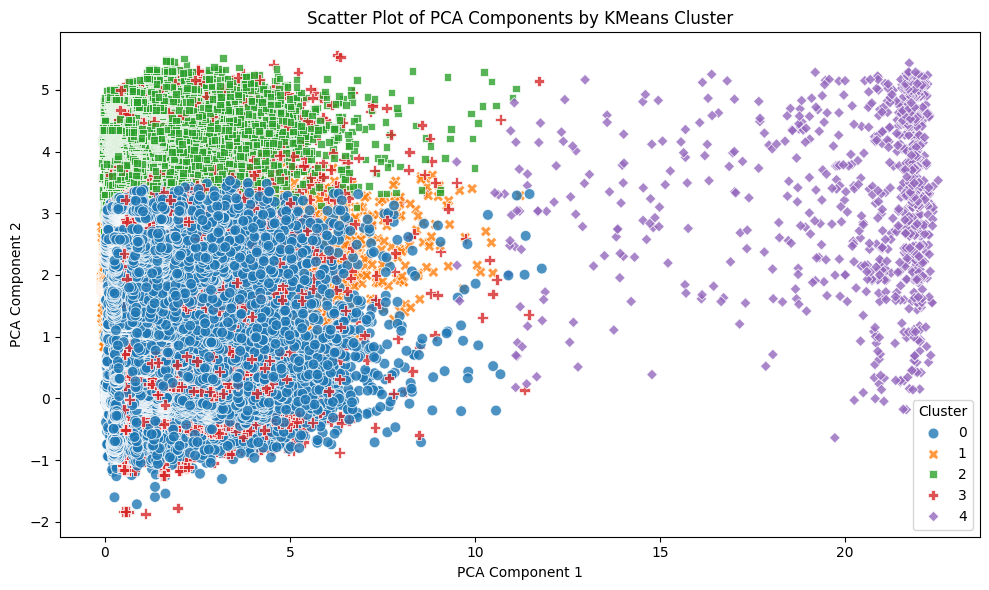

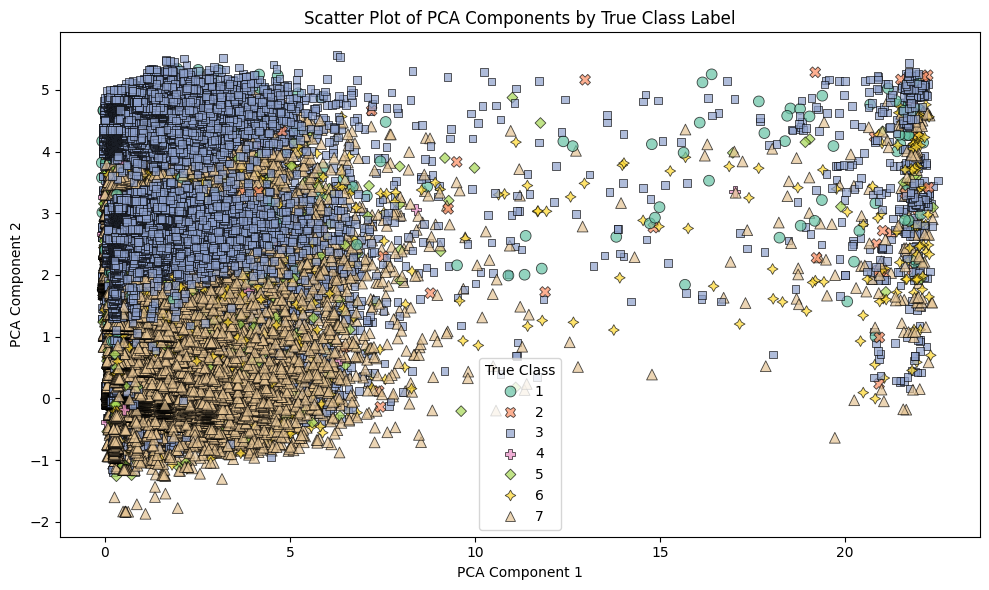

In [9]:
# Plot clusters
import seaborn as sns
import matplotlib.pyplot as plt

# PCA 1 distribution by Cluster
plt.figure(figsize=(10,6))
sns.boxplot(data=pdf, x='cluster', y='x')
plt.title("Distribution of PCA 1 by Cluster")
plt.xlabel("Cluster")
plt.ylabel("PCA Component 1")
plt.tight_layout()
plt.show()

# PCA 2 distribution by Cluster
plt.figure(figsize=(10,6))
sns.boxplot(data=pdf, x='cluster', y='y')
plt.title("Distribution of PCA 2 by Cluster")
plt.xlabel("Cluster")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

# Scatter plot of PCA-reduced features by cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=pdf, x='x', y='y', hue='cluster', style='cluster', palette='tab10', s=60, edgecolor='w', alpha=0.8)
plt.title("Scatter Plot of PCA Components by KMeans Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()

# Scatter plot of PCA-reduced features by true labels
plt.figure(figsize=(10,6))
sns.scatterplot(data=pdf, x='x', y='y', hue='target', style='target', palette='Set2', s=60, edgecolor='k', alpha=0.7)
plt.title("Scatter Plot of PCA Components by True Class Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="True Class", loc="best")
plt.tight_layout()
plt.show()



### **Step 9: Train Local Classifiers per Cluster and Compare**

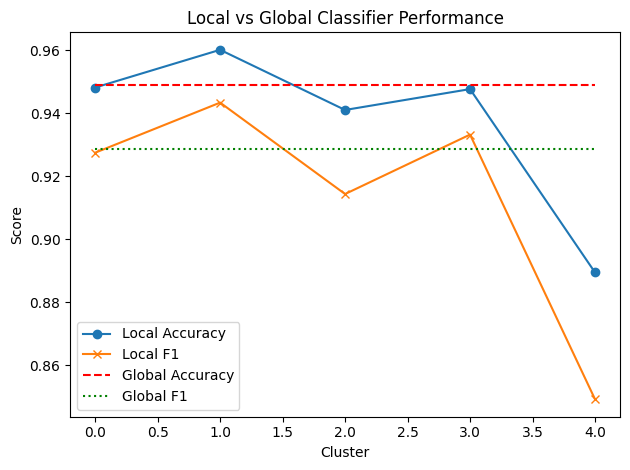

In [10]:
local_metrics = []
for i in range(kmeans.getK()):
    c_data = clustered_df.filter(col("cluster") == i)
    train_c, test_c = c_data.randomSplit([0.8, 0.2], seed=42)
    model_c = RandomForestClassifier(labelCol="target", featuresCol="features").fit(train_c)
    preds_c = model_c.transform(test_c)
    acc = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy").evaluate(preds_c)
    f1 = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="f1").evaluate(preds_c)
    local_metrics.append({'Cluster': i, 'Accuracy': acc, 'F1': f1})

# Compare local vs global
local_df = pd.DataFrame(local_metrics)
plt.plot(local_df['Cluster'], local_df['Accuracy'], marker='o', label='Local Accuracy')
plt.plot(local_df['Cluster'], local_df['F1'], marker='x', label='Local F1')
plt.hlines(global_scores['accuracy'], 0, 4, colors='red', linestyles='dashed', label='Global Accuracy')
plt.hlines(global_scores['f1_score'], 0, 4, colors='green', linestyles='dotted', label='Global F1')
plt.title("Local vs Global Classifier Performance")
plt.xlabel("Cluster")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


### **Step 10: Balance the Dataset and Train Again**

In [11]:
# Undersample each class to match minority
class_counts = df.groupBy("target").count().orderBy("count").collect()
min_count = class_counts[0]["count"]
balanced_parts = [df.filter(col("target") == row["target"]).sample(False, min_count / row["count"], seed=42) for row in class_counts]
df_balanced = balanced_parts[0]
for part in balanced_parts[1:]:
    df_balanced = df_balanced.union(part)

train_bal, test_bal = df_balanced.randomSplit([0.8, 0.2], seed=42)
rf_bal = RandomForestClassifier(labelCol="target", featuresCol="features", numTrees=100)
pipeline_bal = Pipeline(stages=indexers + [imputer, assembler, scaler, rf_bal])
model_bal = pipeline_bal.fit(train_bal)
predictions_bal = model_bal.transform(test_bal)

# Metrics for balanced model
print("\n Balanced Model Metrics:")
for name, metric in metrics.items():
    score = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName=metric).evaluate(predictions_bal)
    print(f"{name.title()}: {score:.4f}")



 Balanced Model Metrics:
Accuracy: 0.9169
F1_Score: 0.9168
Weighted_Precision: 0.9219
Weighted_Recall: 0.9169
